<a href="https://colab.research.google.com/github/FredLongo/MLDL/blob/main/CNN_P2_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
data_rep_path       = "D:/Databases/Dataset_Project_1_1/Dataset_Project_1/train/"
folder_path       = "D:\\Databases\\Dataset_Project_1_1\\Dataset_Project_1\\train_4000"
test_predict_folder_name = "D:\\Databases\\Dataset_Project_1_1\\Dataset_Project_1\\test_prediction"  # New prediction directory

picture_size = 224
no_of_classes = 3
batch_size = 32
epochs = 20


In [ ]:
# Original data set was too large so we shrunk it to 4,000 per Class
'''
#  Only When Needed
from Catagory_Data_Handler import Catagory_Data_Handle
file_copyer = Catagory_Data_Handle(data_rep_path,test_predict_folder_name,50 )
file_copyer.copy_files()
'''

'\n#  Only When Needed\nfrom Catagory_Data_Handler import Catagory_Data_Handle\nfile_copyer = Catagory_Data_Handle(data_rep_path,test_predict_folder_name,50 )\nfile_copyer.copy_files()\n'

In [ ]:
# Show counts
from KT1_Data_Handler import KT1_Data_Handler
h = KT1_Data_Handler(data_rep_path)
h.count_files_in_categories()
h = KT1_Data_Handler(folder_path)
h.count_files_in_categories()
h = KT1_Data_Handler(test_predict_folder_name)
h.count_files_in_categories()

Class 1 Touch: 10166 files
Class 2 No hands: 10195 files
Class 3 No Touch w Hands: 10646 files
Class 1 Touch: 4000 files
Class 2 No hands: 4000 files
Class 3 No Touch w Hands: 4000 files
Class 1 Touch: 50 files
Class 2 No hands: 50 files
Class 3 No Touch w Hands: 50 files


In [ ]:

# Create a dataset for training and validation by splitting
# data to 80% training and 20% validation
# files are randomly selected


train_ds = tf.keras.utils.image_dataset_from_directory(
    folder_path,
    labels="inferred",
    label_mode="categorical",
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(picture_size, picture_size),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear"
)

# Create a dataset for validation
val_ds = tf.keras.utils.image_dataset_from_directory(
    folder_path,
    labels="inferred",
    label_mode="categorical",
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(picture_size, picture_size),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear"
)


Found 12000 files belonging to 3 classes.
Using 9600 files for training.
Found 12000 files belonging to 3 classes.
Using 2400 files for validation.


In [ ]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


In [ ]:

model = Sequential()

#1st CNN layer
#model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(Input(shape=(picture_size, picture_size, 1))),  # Explicit Input layer))
model.add(Conv2D(64,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))


In [ ]:

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt,            loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 128)  │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 56, 56, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 56, 56, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,02

 Total params: 28,987,139 (110.58 MB)

 Trainable params: 28,983,171 (110.56 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [ ]:
print("Start Time:",(datetime.now()).strftime("%H:%M:%S"))

callbacks_list = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                  ModelCheckpoint("model.keras", monitor='val_accuracy', save_best_only=True),
                  ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_delta=0.0001)]

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks_list
)


print("End Time:",(datetime.now()).strftime("%H:%M:%S"))


Start Time: 03:11:06
Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 3569s 12s/step - accuracy: 0.4862 - loss: 1.1265 - val_accuracy: 0.4479 - val_loss: 1.1396 - learning_rate: 1.0000e-04
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1950s 6s/step - accuracy: 0.8021 - loss: 0.4948 - val_accuracy: 0.7733 - val_loss: 0.5810 - learning_rate: 1.0000e-04
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1943s 6s/step - accuracy: 0.9037 - loss: 0.2594 - val_accuracy: 0.8833 - val_loss: 0.2976 - learning_rate: 1.0000e-04
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1944s 6s/step - accuracy: 0.9415 - loss: 0.1665 - val_accuracy: 0.9504 - val_loss: 0.1401 - learning_rate: 1.0000e-04
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1950s 7s/step - accuracy: 0.9662 - loss: 0.1027 - val_accuracy: 0.9604 - val_loss: 0.1178 - learning_rate: 1.0000e-04
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1947s 6s/step - accuracy: 0.9753 - loss: 0.0760 - val_accuracy: 0.9767 - val_loss: 0.0800 - learning_rate: 1.0000e-04
Epoch 7/20
300/300 ━━━━━━━━━━━

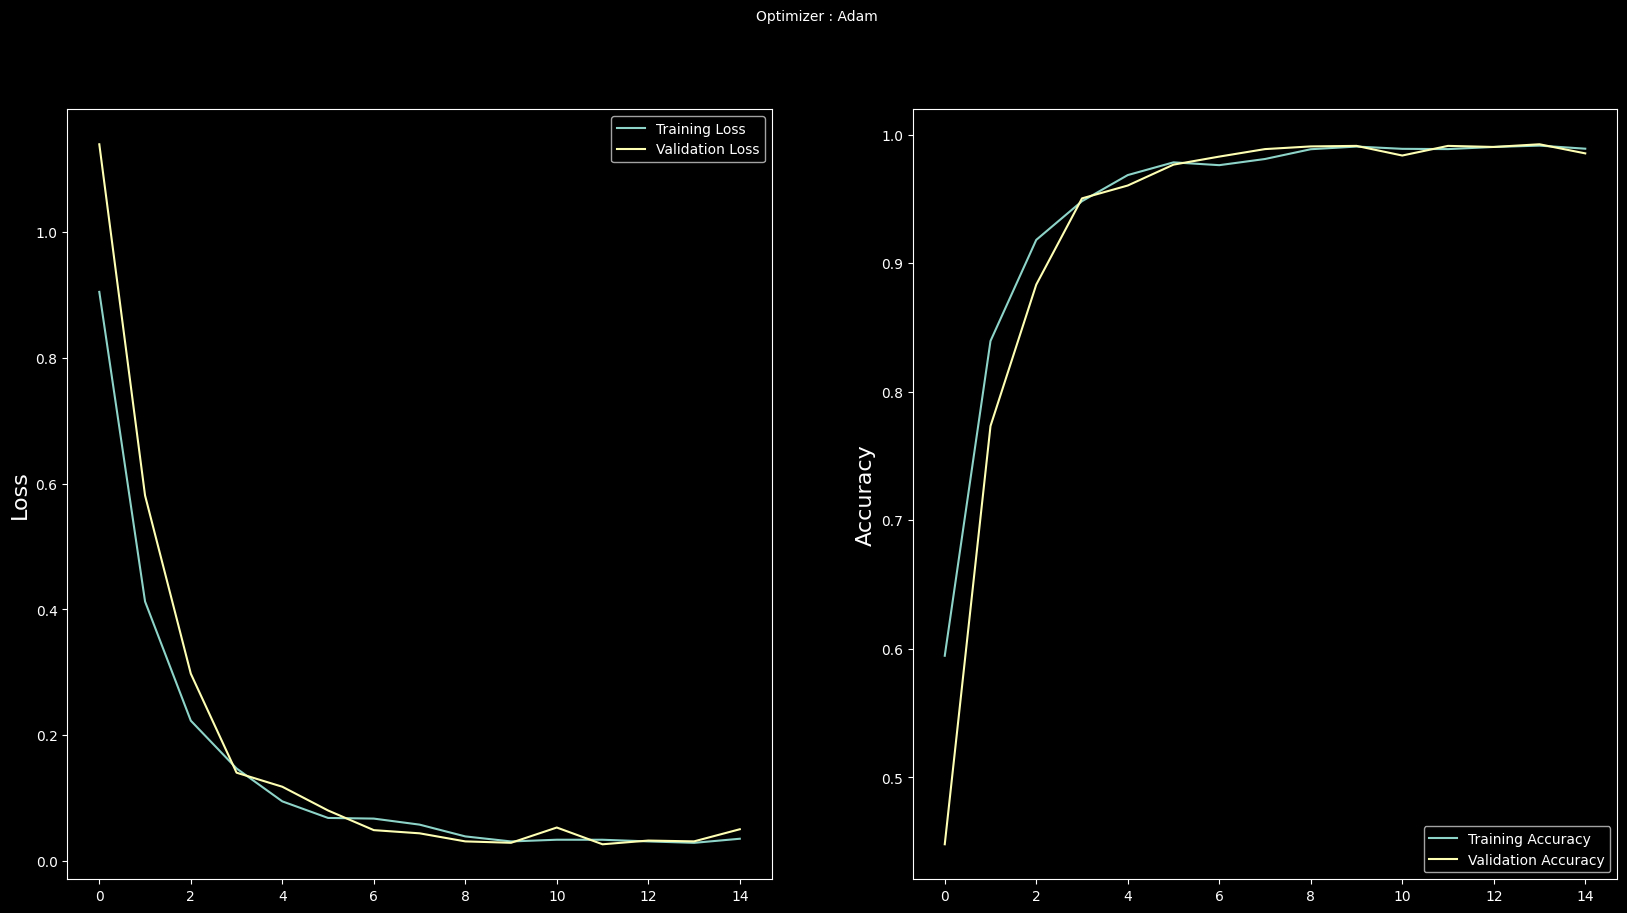

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Test Prediction data generator
test_predict_generator = tf.keras.utils.image_dataset_from_directory(
    test_predict_folder_name,
    labels="inferred",
    label_mode="categorical",
    color_mode="grayscale",
    image_size=(picture_size, picture_size),
    shuffle=True,
    seed=123,
    interpolation="bilinear")

Found 150 files belonging to 3 classes.


In [ ]:
# Predict the class of the new data
predictions = model.predict(test_predict_generator)

predicted_classes = np.argmax(predictions, axis=1)

true_classes =  np.array([])
for x , y in test_predict_generator:
    true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])

# Classification report
class_labels = {label: index for index, label in enumerate(test_predict_generator.class_names)}
report = classification_report(true_classes, predicted_classes, target_names=class_labels)



5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 936ms/step


In [ ]:
print(report)

                          precision    recall  f1-score   support

           Class 1 Touch       0.33      0.32      0.32        50
        Class 2 No hands       0.30      0.30      0.30        50
Class 3 No Touch w Hands       0.35      0.36      0.36        50

                accuracy                           0.33       150
               macro avg       0.33      0.33      0.33       150
            weighted avg       0.33      0.33      0.33       150



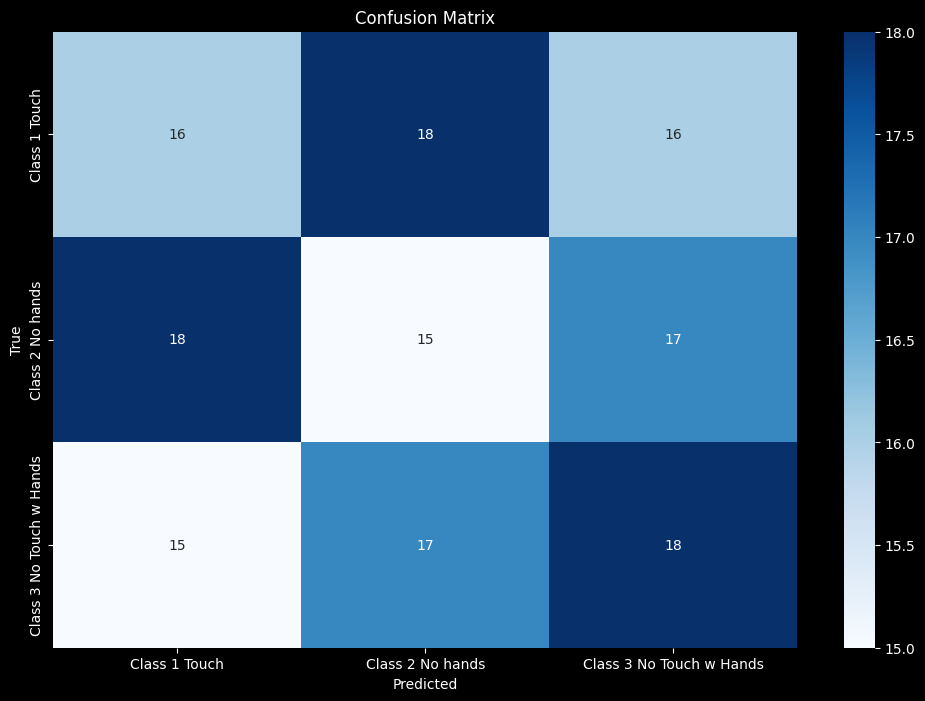

In [ ]:
# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()